In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hardfakevsrealfaces/data.csv
/kaggle/input/hardfakevsrealfaces/fake/fake_218.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_94.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_289.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_507.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_615.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_636.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_160.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_559.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_488.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_93.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_661.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_297.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_610.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_474.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_154.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_308.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_527.jpg
/kaggle/input/hardfakevsrealfaces/fake/fake_593.jpg
/kaggle/input/hardfakev

In [2]:
import os
import random
import gc
import warnings
import itertools

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split

In [3]:
# CSV dosyasını yükleme
data_df = pd.read_csv('/kaggle/input/hardfakevsrealfaces/data.csv').sample(frac=1)

In [4]:
data_df.head()

,images_id,label
623,fake_13,fake
105,real_194,real
182,real_263,real
972,fake_444,fake
151,real_235,real


In [5]:
data_df.isnull().sum()

images_id    0
label        0
dtype: int64

In [6]:
# Resim dosyalarının yollarını ve etiketlerini güncelleme
data_df['path'] = data_df['images_id'].apply(lambda x: os.path.join('/kaggle/input/hardfakevsrealfaces/real', x+'.jpg') if x.startswith('real') else os.path.join('/kaggle/input/hardfakevsrealfaces/fake', x+'.jpg'))
data_df['label'] = data_df['label'].map(lambda x: 1 if x == 'fake' else 0)

In [7]:
data_df.head()

,images_id,label,path
623,fake_13,1,/kaggle/input/hardfakevsrealfaces/fake/fake_13...
105,real_194,0,/kaggle/input/hardfakevsrealfaces/real/real_19...
182,real_263,0,/kaggle/input/hardfakevsrealfaces/real/real_26...
972,fake_444,1,/kaggle/input/hardfakevsrealfaces/fake/fake_44...
151,real_235,0,/kaggle/input/hardfakevsrealfaces/real/real_23...


<BarContainer object of 2 artists>

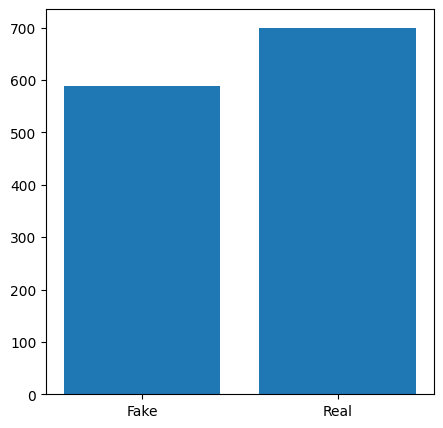

In [8]:
# Sınıf dengesini kontrol et.
fig = plt.figure(figsize=(5,5))
plt.bar(data_df['label'].value_counts().index, data_df['label'].value_counts(), tick_label=['Real','Fake'])

In [9]:
# Eğitim, doğrulama ve test kümelerini oluşturma
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

In [10]:
print("Eğitim veri kümesindeki örnek sayısı:", len(train_df))
print("Doğrulama veri kümesindeki örnek sayısı:", len(val_df))
print("Test veri kümesindeki örnek sayısı:", len(test_df))

Eğitim veri kümesindeki örnek sayısı: 773
Doğrulama veri kümesindeki örnek sayısı: 258
Test veri kümesindeki örnek sayısı: 258


In [11]:
data_transforms = transforms.Compose([
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop(size=(224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.img_labels = dataframe['label']
        self.img_paths = dataframe['path']
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths.iloc[idx])
        label = self.img_labels.iloc[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Veri kümesine dönüşümleri uygulama
train_dataset = CustomImageDataset(train_df, transform=data_transforms)
val_dataset = CustomImageDataset(val_df, transform=data_transforms)
test_dataset = CustomImageDataset(test_df, transform=data_transforms)

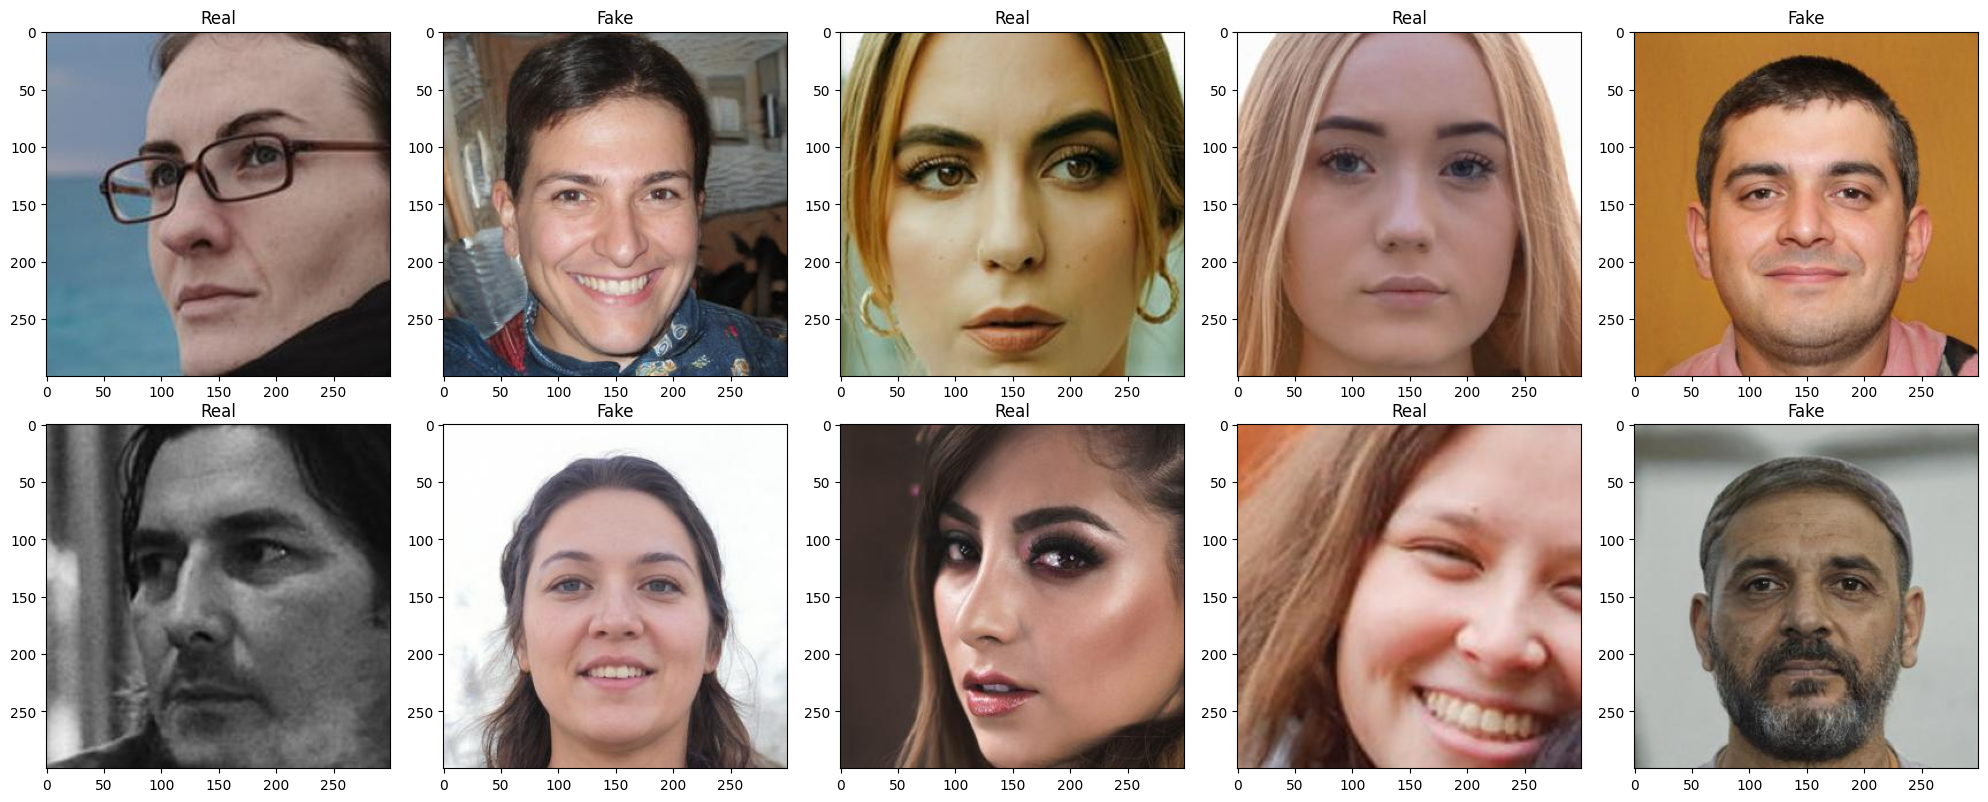

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Eğitim veri kümesinden birkaç örnek gösterme
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i in range(2):
    for j in range(5):
        index = i * 5 + j
        img_path = train_df.iloc[index]['path']
        label = train_df.iloc[index]['label']
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title('Fake' if label == 1 else 'Real')
      

plt.tight_layout()
plt.show()

In [14]:
# Veri yükleyicilerini oluşturma
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


pretrained_model = models.shufflenet_v2_x1_0(pretrained=True)


feature_extractor = nn.Sequential(*list(pretrained_model.children())[:-1])


classifier_layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(50176, 128), 
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)


model = nn.Sequential(
    feature_extractor,
    classifier_layers
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

sample_input = torch.randn(1, 3, 224, 224).to(device)
output = model(sample_input)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 62.1MB/s]


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models


pretrained_shufflenet = models.shufflenet_v2_x1_0(pretrained=True)

pretrained_squeezenet = models.squeezenet1_1(pretrained=True)

shufflenet_features = nn.Sequential(*list(pretrained_shufflenet.children())[:-1])


squeezenet_features = nn.Sequential(
    *list(pretrained_squeezenet.features.children()),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(512, 1024)  # SqueezeNet özelliğini boyutunu 1024'e yükseltin
)


classifier_layers = nn.Sequential(
    nn.Linear(2048, 128),  # ShuffleNet ve SqueezeNet özelliklerinin toplam boyutu 2048'dir
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 1),
    nn.Sigmoid()
)


class HybridModel(nn.Module):
    def __init__(self, shufflenet_features, squeezenet_features, classifier_layers):
        super(HybridModel, self).__init__()
        self.shufflenet_features = shufflenet_features
        self.squeezenet_features = squeezenet_features
        self.classifier_layers = classifier_layers

    def forward(self, x):
        shufflenet_output = self.shufflenet_features(x)
        squeezenet_output =self.squeezenet_features(x)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 52.1MB/s]


Epoch 1/60, Training Loss: 0.4286, Training Accuracy: 0.7930, Validation Loss: 0.2439, Validation Accuracy: 0.8837
Epoch 2/60, Training Loss: 0.2363, Training Accuracy: 0.9069, Validation Loss: 0.2714, Validation Accuracy: 0.8992
Epoch 3/60, Training Loss: 0.2602, Training Accuracy: 0.8900, Validation Loss: 0.1515, Validation Accuracy: 0.9380
Epoch 4/60, Training Loss: 0.1473, Training Accuracy: 0.9405, Validation Loss: 0.1697, Validation Accuracy: 0.9457
Epoch 5/60, Training Loss: 0.1638, Training Accuracy: 0.9314, Validation Loss: 0.1839, Validation Accuracy: 0.9186
Epoch 6/60, Training Loss: 0.1846, Training Accuracy: 0.9198, Validation Loss: 0.0852, Validation Accuracy: 0.9729
Epoch 7/60, Training Loss: 0.1590, Training Accuracy: 0.9340, Validation Loss: 0.1169, Validation Accuracy: 0.9535
Epoch 8/60, Training Loss: 0.1760, Training Accuracy: 0.9444, Validation Loss: 0.1121, Validation Accuracy: 0.9612
Epoch 9/60, Training Loss: 0.1125, Training Accuracy: 0.9534, Validation Loss: 0

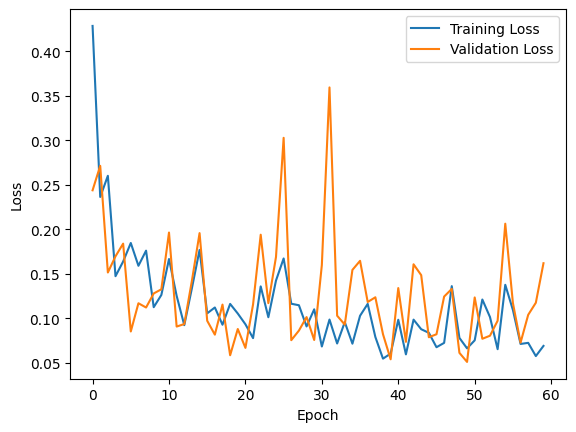

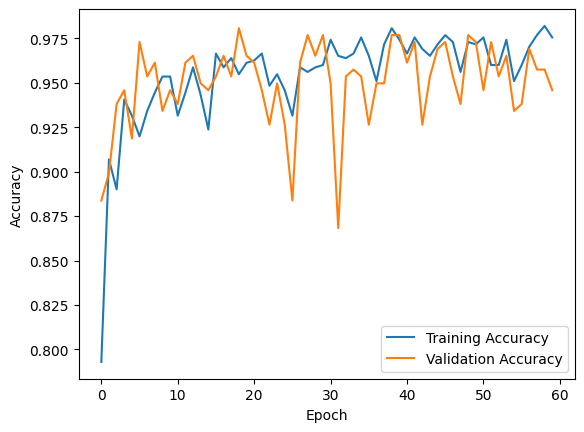

In [17]:
import matplotlib.pyplot as plt

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=100):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            predicted = torch.round(outputs)
            total_train += labels.size(0)
            correct_train += (predicted == labels.unsqueeze(1)).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels.unsqueeze(1).float())
                val_loss += loss.item() * inputs.size(0)
                predicted = torch.round(outputs)
                total_val += labels.size(0)
                correct_val += (predicted == labels.unsqueeze(1)).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Training Loss: {epoch_loss:.4f}, "
              f"Training Accuracy: {train_accuracy:.4f}, "
              f"Validation Loss: {val_loss:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}")

    # Plot losses
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot accuracies
    plt.figure()
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Train and validate the model
train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=60)

In [18]:
import torch

def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

# Kullanımı:
save_model(model, "model_weights.pth")

Model saved to model_weights.pth


In [19]:
import torch

# Modelin performansını değerlendirme fonksiyonu
def evaluate_model(model, test_loader, criterion):
    # Modeli değerlendirme modunda ayarlayın
    model.eval()

    # Loss ve doğruluk değerlerini saklamak için değişkenler oluşturun
    test_loss = 0
    correct = 0
    total = 0

    # Test veri kümesi üzerinde tahmin yapın ve kaybı hesaplayın
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()

            # Doğruluk hesaplaması
            predicted = torch.round(outputs).squeeze().cpu().numpy()
            total += labels.size(0)
            correct += (predicted == labels.cpu().numpy()).sum().item()

    # Test kaybını ve doğruluğunu hesaplayın
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    return test_loss, test_accuracy

# Modeli değerlendirin
test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0046
Test Accuracy: 93.4109


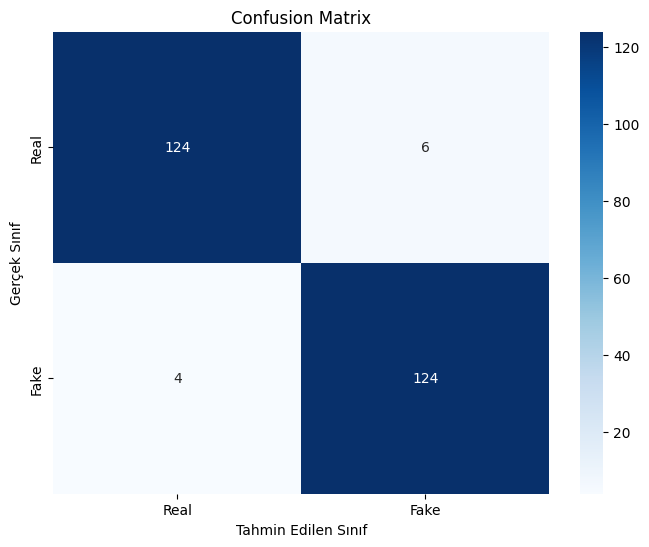

In [20]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Modeli değerlendirme modunda ayarlayın
model.eval()

# Test veri kümesi üzerinde tahmin yapın
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs).squeeze().cpu().numpy()  # Tahminleri numpy dizisine dönüştürün
        y_pred.extend(predicted)
        y_true.extend(labels.cpu().numpy())  # Gerçek etiketleri numpy dizisine dönüştürün

# Karışıklık matrisini hesaplayın
cm = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştirin
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()

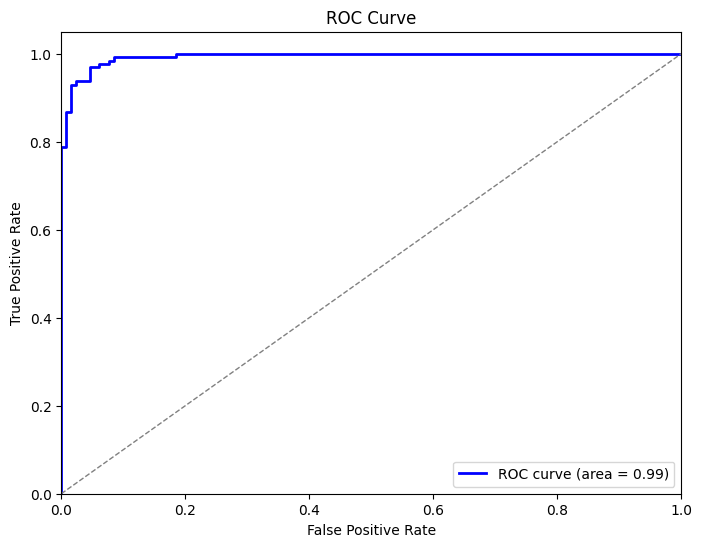

In [21]:
from sklearn.metrics import roc_curve, auc
import numpy as np


model.eval()


y_scores = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = outputs.squeeze().cpu().numpy()  # Tahminleri numpy dizisine dönüştürün
        y_scores.extend(predicted)
        y_true.extend(labels.cpu().numpy())  # Gerçek etiketleri numpy dizisine dönüştürün


fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizdirin
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [22]:
from sklearn.metrics import classification_report

# Modeli değerlendirme modunda ayarlayın
model.eval()

# Test veri kümesi üzerinde tahmin yapın
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.round(outputs).squeeze().cpu().numpy()  # Tahminleri numpy dizisine dönüştürün
        y_pred.extend(predicted)
        y_true.extend(labels.cpu().numpy())  # Gerçek etiketleri numpy dizisine dönüştürün

# Tahminleri ikili hale getirin (0 veya 1)
y_pred_binary = (np.array(y_pred) > 0.5).astype('int')

# Sınıflandırma raporunu hesaplayın ve yazdırın
print(classification_report(y_true, y_pred_binary))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       130
           1       0.99      0.97      0.98       128

    accuracy                           0.98       258
   macro avg       0.98      0.98      0.98       258
weighted avg       0.98      0.98      0.98       258

